In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy.stats import ttest_ind
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.svm import SVC
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
"""Group 15 data science project
DATASET:
(https://www.kaggle.com/competitions/playground-series-s4e11/data)

PROCESS:
1. Load and clean the data
2. EDA - Exploring data
3. Data Pre-processing
4. Creating model
5. Cross-validated training
6. Evaluation of model
"""

'Group 15 data science project\nDATASET:\n(https://www.kaggle.com/competitions/playground-series-s4e11/data)\n\nPROCESS:\n1. Load and clean the data\n2. EDA - Exploring data\n3. Data Pre-processing\n4. Creating model\n5. Cross-validated training\n6. Evaluation of model\n'

In [ ]:
"""
1. Loading and cleaning data
"""
cleaning_transformations = [
    {'drop': ['id', 'Name', 'City']},
    {'handle_na': []}
]

# Define Cleaner Class
class Cleaner(BaseEstimator, TransformerMixin):
    """
    This class will be used as part of the ML Pipeline for cleaning and handling data
    """
    def __init__(self, transformations):
        self.transformations = transformations
        self.data_analyser = DataAnalyser()

    def fit(self, x, y=None):
      self.data_analyser.view_cleaning_analysis(x, y.copy())
      return self

    def transform(self, x):
        x_temp = x.copy()

        for transformation in self.transformations:
            for transformation_type, column_names in transformation.items():
                if transformation_type == 'handle_na':
                    x_temp = self.deal_with_na_values(x_temp)
                elif transformation_type == 'drop':
                    x_temp = self.drop_unneeded_columns(x_temp, column_names)

        return x_temp

    @staticmethod
    def deal_with_na_values(data, verbose=False):

      mode_fill_columns = ['Financial Stress', 'Dietary Habits']
      zero_fill_column = ['CGPA', 'Degree', 'Profession', 'Academic Pressure',
                          'Study Satisfaction', 'Job Satisfaction',
                          'Work Pressure']

      for col in mode_fill_columns:
        data[col] = data[col].fillna(data[col].mode()[0])

      for col in zero_fill_column:
        data[col] = data[col].fillna(0)

      return data

    @staticmethod
    def drop_unneeded_columns(data, column_names):
        return data.drop(columns=column_names)

In [ ]:
"""
2. EDA - This is the class that will allow us to display information about the data
         The idea is that this information that we can extract/plot will allow us to tweak out data-preprocessing pipeline
         to achieve better and more generalisable results
"""
class DataAnalyser:
  def __init__(self, dataframe=None, target=None):
    self.df = dataframe
    self.target = target

  def view_cleaning_analysis(self, dataframe=None, target=None):
    if dataframe is not None:
      self.df = dataframe
    if target is not None:
      self.target = target

    self.plot_dataset_balance()
    self.display_unique_value_bar_graphs()
    self.column_summary()
    self.plot_gender_distribution_by_depression()
    self.plot_column_distribution()
    self.plot_correlation_matrix()
    self.view_mergeable_columns()

  # Data Cleaning visualisations
  def plot_dataset_balance(self):
    depressed_count = self.df[self.target == 1]
    non_depressed_count = self.df[self.target == 0]

    count_depressed = len(depressed_count)
    count_non_depressed = len(non_depressed_count)
    total = count_depressed + count_non_depressed

    labels = ['Non-Depressed', 'Depressed']
    values = [count_non_depressed, count_depressed]
    colors = ['blue', 'orange']

    plt.figure(figsize=(8, 6))
    bars = plt.bar(labels, values, color=colors)

    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

    plt.xlabel('Class')
    plt.ylabel('Number of Records')
    plt.title('Dataset Balance: Depressed vs. Non-Depressed Records')
    percent_non_depressed = (count_non_depressed / total) * 100
    percent_depressed = (count_depressed / total) * 100
    plt.figtext(0.5, -0.05,
                f"Split: {percent_non_depressed:.1f}% Non-Depressed | {percent_depressed:.1f}% Depressed",
                wrap=True, horizontalalignment='center', fontsize=10)

    plt.tight_layout()
    plt.show()


  def display_unique_value_bar_graphs(self):
    columns = ['Dietary Habits', 'Sleep Duration']

    for column in columns:
      plt.figure(figsize=(10, 6))

      value_counts = self.df[column].value_counts(normalize=True).head(10) * 100
      total_unique = self.df[column].nunique()

      ax = value_counts.sort_values(ascending=False).plot(kind='bar', color='skyblue', edgecolor='black')
      plt.title(f'{column} (Top 10 Unique Values)', fontsize=14)
      plt.xlabel('Category')
      plt.ylabel('Percentage (%)')
      plt.ylim(0, value_counts.max() + 10)

      for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.1f}%', (p.get_x() + p.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=10, color='black')

      plt.text(0.95, 0.95, f'Unique Values: {total_unique}',
              ha='right', va='top', transform=plt.gca().transAxes,
              bbox=dict(facecolor='white', edgecolor='grey'), fontsize=10)

      plt.tight_layout()
      plt.show()

  def view_mergeable_columns(self):
    filtered_df_academic_work = self.df[self.df['Academic Pressure'].notnull() & self.df['Work Pressure'].notnull()]
    print("\nNumber of rows with both Academic and Work Pressure values:", len(filtered_df_academic_work))
    filtered_df_study_job = self.df[self.df['Study Satisfaction'].notnull() & self.df['Job Satisfaction'].notnull()]
    print("\nNumber of rows with both Study Satisfaction and Job Satisfaction values:", len(filtered_df_study_job))

  def plot_gender_distribution_by_depression(self):
      column = 'Gender'

      depressed_df = self.df[self.target == 1]
      non_depressed_df = self.df[self.target == 0]

      depressed_counts = depressed_df[column].value_counts(normalize=True).sort_index() * 100
      non_depressed_counts = non_depressed_df[column].value_counts(normalize=True).sort_index() * 100

      all_genders = sorted(set(depressed_counts.index).union(set(non_depressed_counts.index)))
      depressed_vals = [depressed_counts.get(gender, 0) for gender in all_genders]
      non_depressed_vals = [non_depressed_counts.get(gender, 0) for gender in all_genders]

      x = np.arange(len(all_genders))
      width = 0.35

      plt.figure(figsize=(10, 6))
      plt.bar(x - width/2, non_depressed_vals, width, label='Not Depressed', color='#2ECC71')
      plt.bar(x + width/2, depressed_vals, width, label='Depressed', color='#E74C3C')

      plt.xticks(x, all_genders, rotation=15)
      plt.ylabel('Percentage')
      plt.xlabel('Gender')
      plt.title('Gender Distribution: Depressed vs. Not Depressed')
      plt.legend()
      plt.tight_layout()
      plt.show()

  def plot_column_distribution(self):
    print('PLOTTING COLUMNS')
    # TODO: Verify we have each important column covered
    plots = {'pie_chart': ['Age'] ,
              'bar_graph': ['Have you ever had suicidal thoughts ?'],
              'box_plot': []}

    for plot_type, columns in plots.items():
      if plot_type == 'pie_chart':
        self.plot_distribution_by_depression(columns)
      elif plot_type == 'bar_graph':
        self.plot_bar_graph(columns)
      elif plot_type == 'box_plot':
        self.plot_box_plot(columns)

  def plot_columns(self):
    print("*" * 50)
    print("PLOTTING EACH COLUMN")
    print("*" * 50)

    for col in self.df.columns:
      plt.figure(figsize=(8, 4))
      print(f"Plotting: {col}")

      if pd.api.types.is_numeric_dtype(self.df[col]):
        sns.boxplot(x=self.df[col])
        plt.title(f'Boxplot of {col}')
      else:
        sns.countplot(x=self.df[col], order=self.df[col].value_counts().index[:20])  # limit to top 20 if too many
        plt.title(f'Countplot of {col}')

      plt.tight_layout()
      plt.show()
      print("-" * 50)

  def column_summary(self):
    print("*" * 50)
    print("COLUMN SUMMARY")
    print("*" * 50)

    for col in self.df.columns:
      col_type = 'Numerical' if pd.api.types.is_numeric_dtype(self.df[col]) else 'Categorical'
      null_count = self.df[col].isnull().sum()
      null_percent = (null_count / len(self.df)) * 100

      print(f"Column: {col}")
      print(f"Type: {col_type}")
      print(f"Nulls: {null_count} ({null_percent:.2f}%)")
      print("-" * 50)

  def plot_correlation_matrix(self):
    print('*' * 50)
    print('* Overall Correlation Matrix for Numerical Features')
    print('*' * 50)

    # Select numerical and categorical columns
    numerical_cols = self.df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = self.df.select_dtypes(exclude=[np.number]).columns.tolist()

    # Compute correlation matrix
    corr_mat = self.df[numerical_cols].corr()

    # Create mask and colormap
    mask = np.triu(np.ones_like(corr_mat, dtype=bool))
    cmap = sns.diverging_palette(230, 30, as_cmap=True)

    # Create figure and heatmap
    plt.style.use("default")
    f, ax = plt.subplots(figsize=(9, 7))
    sns.heatmap(
        corr_mat,
        mask=mask,
        cmap=cmap,
        center=0,
        square=False,
        annot=False,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8},
    )

    plt.title("Correlation Matrix\n")
    plt.xticks(fontsize=9, rotation=45)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    plt.show()

  def plot_distribution_by_depression(self, columns):
    for column in columns:
      depressed_df = self.df[self.target == 1][[column]].copy()
      depressed_df["Depression Status"] = "Depressed"

      non_depressed_df = self.df[self.target == 0][[column]].copy()
      non_depressed_df["Depression Status"] = "Not Depressed"

      combined_df = pd.concat([depressed_df, non_depressed_df])

      fig = px.histogram(
          data_frame=combined_df,
          x=column,
          color="Depression Status",
          color_discrete_sequence=['#E74C3C', '#2ECC71'],
          marginal="box",
          nbins=100,
          template="plotly_white"
      )

      fig.update_layout(title=f"Distribution of {column} by Depression Status", title_x=0.5)
      fig.show()

  def plot_bar_graph(self, columns):
    for column in columns:
      depressed_df = self.df[self.target == 1][[column]].copy()
      depressed_df["Depression Status"] = "Depressed"

      non_depressed_df = self.df[self.target == 0][[column]].copy()
      non_depressed_df["Depression Status"] = "Not Depressed"

      # Combine into one DataFrame
      combined_df = pd.concat([depressed_df, non_depressed_df])
      # code for plotting bar graph

      fig = px.histogram(
          data_frame=combined_df,
          x=column,
          color="Depression Status",
          barmode='group',
          histnorm='percent',
          color_discrete_sequence=['#E74C3C', '#2ECC71'],
          template="plotly_white"
      )

      fig.update_layout(
          title=f"{column} Distribution by Depression Status",
          title_x=0.5,
          xaxis_title=column,
          yaxis_title='Percentage',
          bargap=0.2
      )
      fig.show()

  def plot_box_plot(self, columns):
    for column in columns:
      depressed_df = self.df[self.target == 1][column]
      non_depressed_df = self.df[self.target == 0][column]
      # code for plotting box_plot

In [ ]:
"""
3. Data Pre-Processing
"""

# Basic preprocessing configuration
preprocessing_transformations = [
    {'binary_encode': ['Gender', 'Have you ever had suicidal thoughts ?',
                       'Family History of Mental Illness',
                       'Working Professional or Student']},
    {'map_sleep_column': ['Sleep Duration']},
    {'map_diet_column': ['Dietary Habits']},
    {'frequency_encode': ['Profession', 'Degree']},
    {'merge': [{'Academic Pressure', 'Work Pressure'}, {'Study Satisfaction', 'Job Satisfaction'}]},
    {'normalise': ['Financial Stress', 'Age', 'Academic Pressure', 'Work Pressure',
                   'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']}
]

class PreProcessor(BaseEstimator, TransformerMixin):
    """
    This class will handle the Pre-Processin of our data before passing to the Model

    """
    def __init__(self, transformations):
        self.transformations = transformations
        self.mappings = {
            'Gender': {'Male': 0, 'Female': 1},
            'Have you ever had suicidal thoughts ?': {'Yes': 0, 'No': 1},
            'Family History of Mental Illness': {'Yes': 0, 'No': 1},
            'Working Professional or Student': {'Working Professional': 0, 'Student': 1},
        }
        self.sleep_mapping = {
        "More than 8 hours":9,
        'Less than 5 hours':4,
        '5-6 hours':5.5,
        '7-8 hours':7.5,
        '1-2 hours':1.5,
        '6-8 hours':7,
        '4-6 hours':5,
        '6-7 hours':6.5,
        '10-11 hours':10.5,
        '8-9 hours':8.5,
        '9-11 hours':10,
        '2-3 hours':2.5,
        '3-4 hours':3.5,
        'Moderate':6,
        '4-5 hours':4.5,
        '9-6 hours':7.5,
        '1-3 hours':2,
        '1-6 hours':4,
        '8 hours':8,
        '10-6 hours':8,
        'Unhealthy':3,
        'Work_Study_Hours':6,
        '3-6 hours':4.5,
        '9-5':7,
        '9-5 hours':7,
        }
        self.diet_mapping ={
            'More Healty':0,
            'Healthy':1,
            'Less than Healthy':2,
            'Less Healthy':2,
            'Moderate':3,
            'Unhealthy':4,
            'No Healthy':4,
        }

    def fit(self, x, y=None):
      self.data_analyser = DataAnalyser(x,y)
      return self

    def transform(self, x):
        x_temp = x.copy()

        for transformation in self.transformations:
            for transformation_name, column_names in transformation.items():
                if transformation_name == 'drop_columns':
                    x_temp = self.drop_columns(x_temp, column_names)
                elif transformation_name == 'binary_encode':
                    x_temp = self.encode_columns(x_temp, column_names, self.mappings)
                elif transformation_name == 'normalise':
                    x_temp = self.normalise_columns(x_temp, column_names)
                elif transformation_name == 'map_sleep_column':
                    x_temp = self.map_sleep_values(x_temp, column_names, self.sleep_mapping)
                elif transformation_name == 'frequency_encode':
                    x_temp = self.frequency_encode(x_temp, column_names)
                elif transformation_name == 'map_diet_column':
                    x_temp = self.map_dietary_value(x_temp, column_names, self.diet_mapping)
                elif transformation_name == 'merge':
                    x_temp = self.merge_columns(x_temp, column_names)

        return x_temp

    @staticmethod
    def drop_columns(data, column_names):
        data.drop(columns=column_names, inplace=True)
        return data

    @staticmethod
    def encode_columns(data, column_names, mappings):
        for column in column_names:
            if column in mappings:
                data[column] = data[column].map(mappings[column])
        return data

    @staticmethod
    def map_sleep_values(data, column_names, mapping):
        for column in column_names:
            data[column] = data[column].map(mapping)
            data[column] = data[column].fillna(data[column].mode()[0])
        return data

    @staticmethod
    def map_dietary_value(data, column_names, mapping):
        for column in column_names:
            data[column] = data[column].map(mapping)
            data[column] = data[column].fillna(data[column].mode()[0])
        return data


    @staticmethod
    def frequency_encode(data, column_names):
        for column in column_names:
            if column in data.columns:
                freq = data[column].value_counts() / len(data)
                data[column] = data[column].map(freq)
        return data

    @staticmethod
    def one_hot_encode(data, column_names):
        for column in column_names:
            if column in data.columns:
                one_hot = pd.get_dummies(data[column], prefix=column)
                data = pd.concat([data, one_hot], axis=1)
                data.drop(columns=[column], inplace=True)
        return data

    @staticmethod
    def normalise_columns(data, column_names):
        scaler = MinMaxScaler()
        for column in column_names:
            if column in data.columns:
                data[column] = scaler.fit_transform(data[[column]])
        return data


    @staticmethod
    def merge_columns(data, merge_sets):
        for merge_pair in merge_sets:
            col1, col2 = list(merge_pair)[:2]
            merged_col_name = f"Merged_{col1.split()[0]}"

            def smart_merge(row):
                if row.get('Working Professional or Student') == 'Student':
                    return row[col1] if pd.notnull(row[col1]) else row[col2]
                elif row.get('Working Professional or Student') == 'Working Professional':
                    return row[col2] if pd.notnull(row[col2]) else row[col1]
                else:
                    if pd.notnull(row[col1]) and pd.notnull(row[col2]):
                        return (row[col1] + row[col2]) / 2
                    elif pd.notnull(row[col1]):
                        return row[col1]
                    elif pd.notnull(row[col2]):
                        return row[col2]
                    else:
                        return np.nan

            data[merged_col_name] = data.apply(smart_merge, axis=1)

        return data


In [ ]:
"""
4. Creating Model / Training / Evaluating
"""

# Define model parameters
logistic_regression_params = {'max_iter': 1000, 'random_state': 42}
decision_tree_params = {'criterion': 'gini', 'max_depth': 3, 'random_state': 42}
random_forest_params = {'n_estimators': 100, 'max_depth': 5, 'random_state': 42}
svm_params = {'kernel': 'linear', 'C': 1.0}
knn_params = {'n_neighbors': 5}


# Define models
models = {'Logistic_regression': LogisticRegression(**logistic_regression_params),
          'decision_tree': DecisionTreeClassifier(**decision_tree_params),
          # 'SVM': SVC(**svm_params),
          'K-Nearest Neighbors': KNeighborsClassifier(**knn_params)}

class Trainer(BaseEstimator, TransformerMixin):
  """
  This class will handle the training process for building models to predict the binary target
  """
  def __init__(self, models, n_splits=5):
    self.models = models
    self.n_splits = n_splits
    self.results = {}
    self.results_analyser = ResultsAnalyser()

  def fit(self,x,y):
    skf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=42)

    for model_name, model in self.models.items():
      accuracies = []
      tp_percentages, tn_percentages, fp_percentages, fn_percentages = [], [], [], []
      for train_idx, val_idx in skf.split(x, y):
        x_train, x_val = x.iloc[train_idx], x.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model.fit(x_train, y_train)
        y_pred = model.predict(x_val)
        accuracy = accuracy_score(y_val, y_pred)
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred).ravel()

        # Total samples in fold
        total = len(y_val)

        # Store percentages
        tp_percentages.append(tp / total)
        tn_percentages.append(tn / total)
        fp_percentages.append(fp / total)
        fn_percentages.append(fn / total)
        accuracies.append(accuracy)

      self.results[model_name] = {
        'accuracy': np.mean(accuracies),
        'tp%': np.mean(tp_percentages),
        'tn%': np.mean(tn_percentages),
        'fp%': np.mean(fp_percentages),
        'fn%': np.mean(fn_percentages)}
    return self

  def transform(self,x):
    return x

  def get_results(self):
    self.results_analyser.view_results(self.results)

In [ ]:
'''
5. Analysing results
'''

class ResultsAnalyser:
    def __init__(self):
        pass

    def view_results(self, results, fp=None, fn=None, tp=None, tn=None):
        """
        General function that will display:
        1. Individual model results (accuracy, true positives, false positives, etc.)
        2. Confusion Matrix (if FP, FN, TP, TN are provided)
        3. Average F1 Score and Average Significance across all models

        Arguments:
        results : dict - Dictionary containing results from multiple models
        fp, fn, tp, tn : float - Confusion matrix values (optional)
        """

        print('*' * 50)
        print('* Model Performance Results')
        print('*' * 50)
        for model_name, metrics in results.items():
            print(f"{model_name}:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value}")
            print("-" * 50)

        if fp is not None and fn is not None and tp is not None and tn is not None:
            self.create_confusion_matrix(fp, fn, tp, tn)

        self.compute_average_metrics(results)

    def create_confusion_matrix(self, fp, fn, tp, tn):
        """
        Create and display a confusion matrix.

        Arguments:
        fp : float - False Positive rate
        fn : float - False Negative rate
        tp : float - True Positive rate
        tn : float - True Negative rate

        Returns:
        None
        """
        confusion_matrix = {
            "TP": tp,
            "TN": tn,
            "FP": fp,
            "FN": fn
        }

        print('*' * 50)
        print('* Confusion Matrix')
        print('*' * 50)
        print(f"True Positives (TP): {confusion_matrix['TP']}")
        print(f"True Negatives (TN): {confusion_matrix['TN']}")
        print(f"False Positives (FP): {confusion_matrix['FP']}")
        print(f"False Negatives (FN): {confusion_matrix['FN']}")
        print('*' * 50)

    def compute_average_metrics(self, results):
        """
        Compute the average of metrics such as F1 score and significance
        from a results dictionary.

        Arguments:
        results : dict - dictionary of model results with performance metrics

        Returns:
        avg_f1_score : float - Average F1 score of all models
        avg_significance : float - Average significance based on p-value
        """
        f1_scores = []
        significance_values = []

        for model_name, metrics in results.items():
            accuracy = metrics.get('accuracy')
            tp_percentage = metrics.get('tp%')
            tn_percentage = metrics.get('tn%')
            fp_percentage = metrics.get('fp%')
            fn_percentage = metrics.get('fn%')

            f1 = 2 * (tp_percentage * tn_percentage) / (tp_percentage + tn_percentage)
            f1_scores.append(f1)

            p_value = metrics.get('p-value', 0.05)
            significance = p_value < 0.05
            significance_values.append(int(significance))

        avg_f1_score = sum(f1_scores) / len(f1_scores) if f1_scores else 0
        avg_significance = sum(significance_values) / len(significance_values) if significance_values else 0

        print('*' * 50)
        print('* Average Metrics')
        print('*' * 50)
        print(f"Average F1 Score: {avg_f1_score:.2f}")
        print(f"Average Significance: {avg_significance:.2f} (where 1 = significant, 0 = not significant)")
        print('*' * 50)

        return avg_f1_score, avg_significance



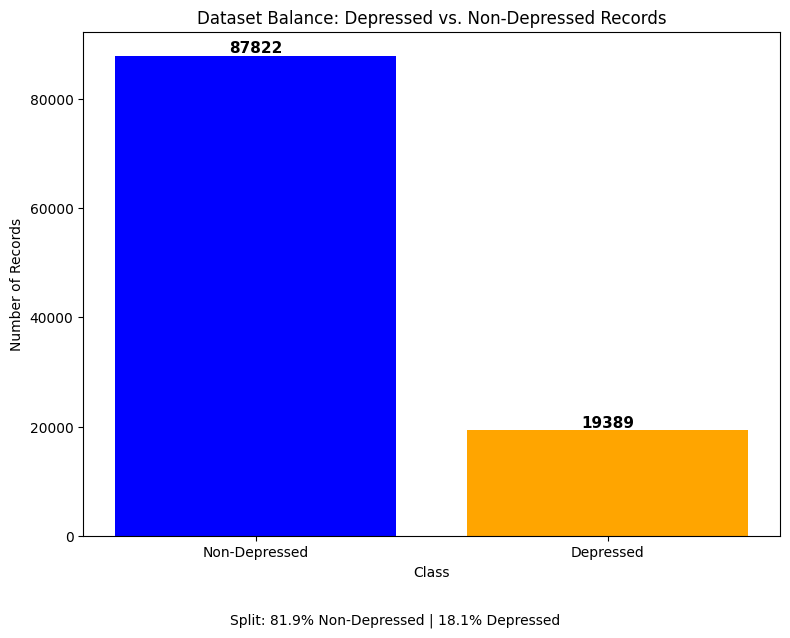

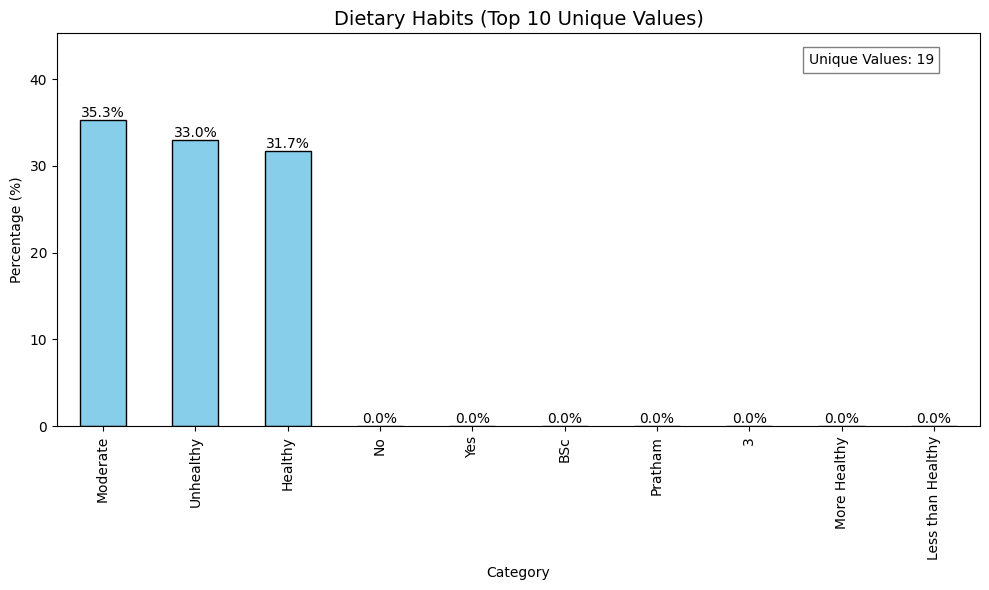

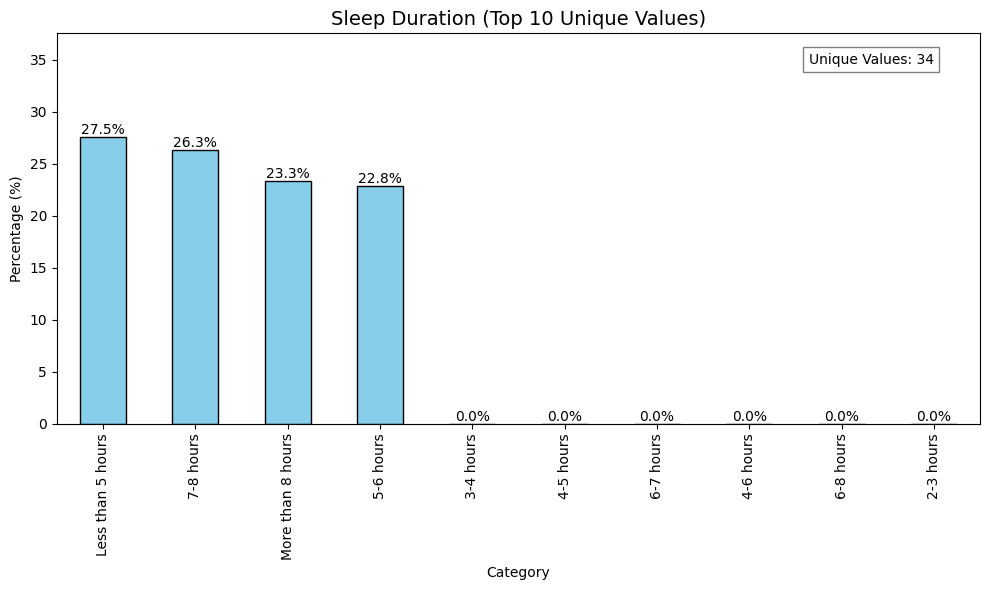

**************************************************
COLUMN SUMMARY
**************************************************
Column: id
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Name
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Gender
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Age
Type: Numerical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: City
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Working Professional or Student
Type: Categorical
Nulls: 0 (0.00%)
--------------------------------------------------
Column: Profession
Type: Categorical
Nulls: 27923 (26.04%)
--------------------------------------------------
Column: Academic Pressure
Type: Numerical
Nulls: 85999 (80.21%)
--------------------------------------------------
Column: Work Pressure
Type: Numerical
Null

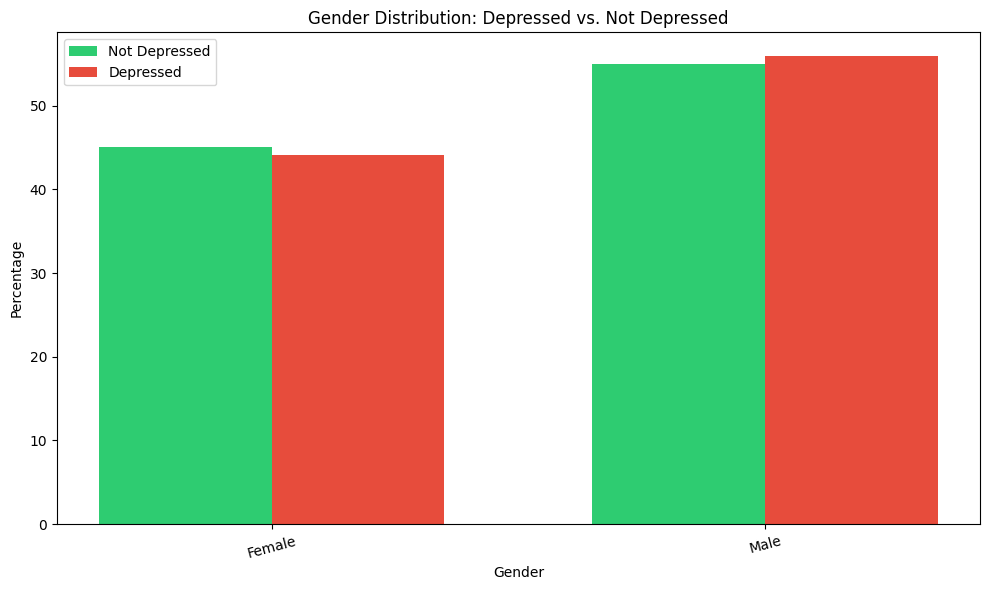

PLOTTING COLUMNS


**************************************************
* Overall Correlation Matrix for Numerical Features
**************************************************


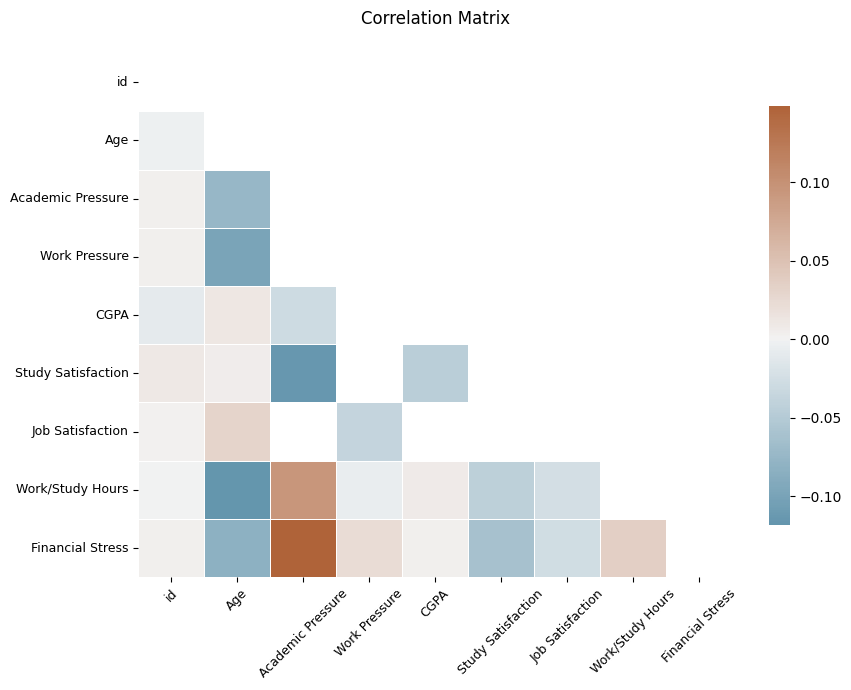


Number of rows with both Academic and Work Pressure values: 0

Number of rows with both Study Satisfaction and Job Satisfaction values: 1
**************************************************
* Model Performance Results
**************************************************
Logistic_regression:
  accuracy: 0.9369654317409675
  tp%: 0.14515301667464564
  tn%: 0.7918124150663218
  fp%: 0.02733860490905312
  fn%: 0.035695963349979425
--------------------------------------------------
decision_tree:
  accuracy: 0.914728916717763
  tp%: 0.13376427114271489
  tn%: 0.7809646455750482
  fp%: 0.03818637440032675
  fn%: 0.04708470888191013
--------------------------------------------------
K-Nearest Neighbors:
  accuracy: 0.923254156894927
  tp%: 0.13397880119423689
  tn%: 0.7892753557006901
  fp%: 0.029875664274684837
  fn%: 0.046870178830388146
--------------------------------------------------
**************************************************
* Average Metrics
*************************************

In [ ]:
dataset = pd.read_csv('train.csv')
dataset = dataset[dataset['Depression'].notnull()]

target = dataset.pop('Depression')

pipeline = Pipeline([
    ('cleaning', Cleaner(cleaning_transformations)),
    ('preprocessor', PreProcessor(preprocessing_transformations)),
    ('training', Trainer(models))
])

pipeline.fit(dataset, target)

model_results = pipeline.named_steps['training'].get_results()